## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [246]:
import warnings
warnings.filterwarnings('ignore')

In [247]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [248]:
# your code here
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

In [249]:
traffic_log = Data1
traffic_log['log'] = np.log(traffic_log['AvgDailyTrafficCount'])
log_mean = np.mean(traffic_log['log'])
traffic_log['log'] = traffic_log['log'] - log_mean
traffic_log.head()

,Longitude,Latitude,AvgDailyTrafficCount,log
0,-80.278366,40.468606,84.0,-3.977526
1,-80.162117,40.384598,95.0,-3.854466
2,-80.221205,40.366778,97.0,-3.833632
3,-80.142455,40.622084,111.0,-3.698812
4,-80.131975,40.544915,125.0,-3.580029


In [250]:
x = traffic_log[['Longitude','Latitude']]
y = traffic_log['log']

In [251]:
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

gp.fit(x, y)

y_pred, sigma = gp.predict(x, return_std=True)

In [252]:
print('optimized kernel:',gp.kernel_)

optimized kernel: 0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)


2) The log marginal likelihood of the training data. (5 pts)

In [253]:
print('log marginal likelihood of the training data:',gp.log_marginal_likelihood_value_)

log marginal likelihood of the training data: -1365.9466919139302


3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

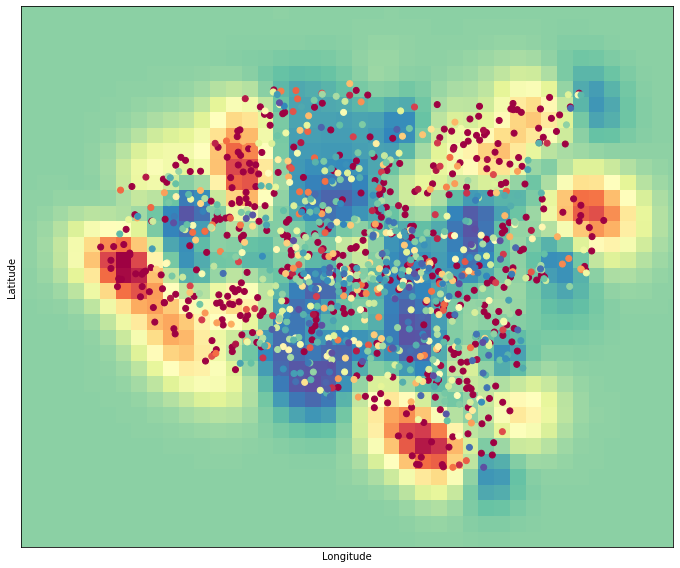

In [254]:
import matplotlib
h = .02  
x_min, x_max = x.iloc[:, 0].min() - 0.1, x.iloc[:, 0].max() + 0.1
y_min, y_max = x.iloc[:, 1].min() - 0.1, x.iloc[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.figure(figsize=(16, 8))
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1], 1))
colormap = matplotlib.cm.get_cmap('Spectral')
colors = [colormap(i) for i in y]
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower",cmap = colormap)
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=colors)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

In [255]:
pred = gp.predict(x)
pred

array([-1.59403962, -0.80083748, -1.24678125, ...,  0.53711094,
        0.30215215,  0.62709241])

In [256]:
traffic_log['predict'] = pred
traffic_log.head()

,Longitude,Latitude,AvgDailyTrafficCount,log,predict
0,-80.278366,40.468606,84.0,-3.977526,-1.594040
1,-80.162117,40.384598,95.0,-3.854466,-0.800837
2,-80.221205,40.366778,97.0,-3.833632,-1.246781
3,-80.142455,40.622084,111.0,-3.698812,-1.251590
4,-80.131975,40.544915,125.0,-3.580029,-1.326580


In [257]:
sensors_over2std = traffic_log[abs(traffic_log['log'] - traffic_log['predict']) > 2 * np.std(pred)]
sensors_over2std

,Longitude,Latitude,AvgDailyTrafficCount,log,predict
0,-80.278366,40.468606,84.0,-3.977526,-1.594040
1,-80.162117,40.384598,95.0,-3.854466,-0.800837
2,-80.221205,40.366778,97.0,-3.833632,-1.246781
3,-80.142455,40.622084,111.0,-3.698812,-1.251590
4,-80.131975,40.544915,125.0,-3.580029,-1.326580
...,...,...,...,...,...
1069,-79.847233,40.333156,11550.0,0.946098,-0.120209
1093,-80.131749,40.512103,11967.0,0.981566,-0.353124
1094,-79.880156,40.266020,11999.0,0.984236,-0.074733
1095,-80.123642,40.516435,12009.0,0.985069,-0.355448


In [258]:
over2std_percent = 100 * len(sensors_over2std) / len(traffic_log)
over2std_percent

11.659192825112108

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

In [259]:
traffic_log['label'] = 0
traffic_log.loc[traffic_log['log'] - traffic_log['predict'] > 2 * np.std(pred),'label'] = 1
traffic_log.loc[traffic_log['predict'] - traffic_log['log'] > 2 * np.std(pred),'label'] = 2
traffic_log

,Longitude,Latitude,AvgDailyTrafficCount,log,predict,label
0,-80.278366,40.468606,84.0,-3.977526,-1.594040,2
1,-80.162117,40.384598,95.0,-3.854466,-0.800837,2
2,-80.221205,40.366778,97.0,-3.833632,-1.246781,2
3,-80.142455,40.622084,111.0,-3.698812,-1.251590,2
4,-80.131975,40.544915,125.0,-3.580029,-1.326580,2
...,...,...,...,...,...,...
1110,-79.843684,40.498619,13428.0,1.096755,0.643046,0
1111,-79.926842,40.425383,13713.0,1.117757,0.491972,0
1112,-80.065730,40.397582,13822.0,1.125674,0.537111,0
1113,-79.863848,40.429878,14172.0,1.150681,0.302152,0


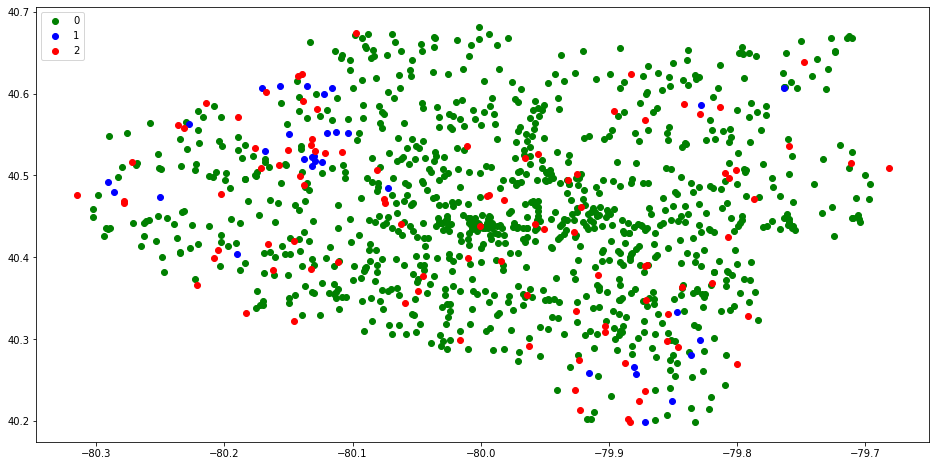

In [260]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax1.scatter(traffic_log.loc[traffic_log['label']== 0]['Longitude'], traffic_log.loc[traffic_log['label']== 0]['Latitude'], c='g', label='0')
ax1.scatter(traffic_log.loc[traffic_log['label']== 1]['Longitude'], traffic_log.loc[traffic_log['label']== 1]['Latitude'], c='b', label='1')
ax1.scatter(traffic_log.loc[traffic_log['label']== 2]['Longitude'], traffic_log.loc[traffic_log['label']== 2]['Latitude'], c='r', label='2')
plt.legend(loc='upper left');
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 2 points, center (10, 10), standard deviation 1

B: 200 points, center (15, 20), standard deviation 1

C: 150 points, center (35, 5), standard deviation 5

D: 100 points, center (0, 0), standard deviation 0.1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(10, 11)	Anomaly / Not Anomaly

(15, 19)	Anomaly / Not Anomaly

(35, 2)		Anomaly / Not Anomaly

(1, 0)		Anomaly / Not Anomaly

### Your solutions here

(10, 11) Anomaly : the distance to center is 1 which is equal to std, but the cluster size is too small, so it is anomaly.

(15, 19)  Not Anomaly : the distance to center is 1 which is equal to std, as the cluster size is big, it is not anomaly.

(35, 2) Not Anomaly : the distance to center is 3 which is smaller than std 5 and the cluster size is big enough.

(1, 0)   Anomaly : the distance to center is 1 which is much larger than std 0.1, though the cluster size is big enough, it is anomaly.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [261]:
Data2 = pd.read_csv("2022CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",20,10.0,20,35,32,63.0,16,32.0,578.1,...,15.0,5.1,28.0,12.9,272.0,69.0,9.5,15,87.0,41
1,"Baldwin, Alabama",17,8.0,20,30,28,75.0,22,32.0,336.0,...,12.0,4.4,18.0,10.1,204.0,75.0,7.2,12,83.0,38
2,"Barbour, Alabama",31,12.0,28,40,42,50.0,14,38.0,895.2,...,38.0,6.0,54.0,7.3,414.0,82.0,9.0,15,84.0,37
3,"Bibb, Alabama",25,10.0,25,41,38,11.0,16,21.0,540.3,...,22.0,5.4,37.0,8.9,89.0,103.0,9.4,11,88.0,55
4,"Blount, Alabama",23,8.0,22,39,33,23.0,16,15.0,404.7,...,19.0,4.8,23.0,7.4,483.0,105.0,9.4,10,88.0,60


In [262]:
# your code here
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

In [263]:
Data2.dtypes

County                                   object
'\% Reporting Fair/Poor Health'           int64
'\% Low birth weight births'            float64
'\% Smokers'                              int64
'\% Obese'                                int64
'\% Physically Inactive'                  int64
'\% With Access To Exercise'            float64
'\% Excessive Drinking'                   int64
'\% Alcohol-Impaired Driving Deaths'    float64
'Chlamydia Rate'                        float64
'Teen Birth Rate'                       float64
'\% Uninsured'                          float64
'Preventable Hosp. Rate'                float64
'\% Mammography'                        float64
'Graduation Rate'                         int64
'\% Some College'                         int64
'\% Unemployed'                         float64
'\% Children in Poverty'                float64
'80/20 Income Ratio'                    float64
'\% Single-Parent Households'           float64
'Association Rate'                      

In [264]:
Data2_clean =  Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]
Data2_clean.index = Data2['County']
Data2_clean = Data2_clean.apply(pd.to_numeric, errors='coerce')
Data2_clean.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",20,35,272.0,5.1,15.0,9.5
"Baldwin, Alabama",20,30,204.0,4.4,12.0,7.2
"Barbour, Alabama",28,40,414.0,6.0,38.0,9.0
"Bibb, Alabama",25,41,89.0,5.4,22.0,9.4
"Blount, Alabama",22,39,483.0,4.8,19.0,9.4


In [265]:
Data2_clean = Data2_clean.dropna()

In [266]:
Data2_clean.dtypes

'\% Smokers'                  int64
'\% Obese'                    int64
'Violent Crime Rate'        float64
'80/20 Income Ratio'        float64
'\% Children in Poverty'    float64
'Average Daily PM2.5'       float64
dtype: object

In [267]:
Data2_clean

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",20,35,272.0,5.1,15.0,9.5
"Baldwin, Alabama",20,30,204.0,4.4,12.0,7.2
"Barbour, Alabama",28,40,414.0,6.0,38.0,9.0
"Bibb, Alabama",25,41,89.0,5.4,22.0,9.4
"Blount, Alabama",22,39,483.0,4.8,19.0,9.4
...,...,...,...,...,...,...
"Sublette, Wyoming",17,26,66.0,5.6,7.0,5.5
"Sweetwater, Wyoming",17,34,300.0,4.2,8.0,5.4
"Uinta, Wyoming",19,30,71.0,3.7,10.0,6.9


In [268]:
for column in Data2_clean.columns.unique():
    Data2_clean[column] = pd.cut(Data2_clean[column],5, labels=[0,1,2,3,4])

In [269]:
Data2_clean

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",2,2,0,2,1,1
"Baldwin, Alabama",2,1,0,1,0,1
"Barbour, Alabama",3,3,1,2,3,1
"Bibb, Alabama",3,3,0,2,1,1
"Blount, Alabama",2,3,1,2,1,1
...,...,...,...,...,...,...
"Sublette, Wyoming",1,0,0,2,0,0
"Sweetwater, Wyoming",1,2,0,1,0,0
"Uinta, Wyoming",2,1,0,1,0,1


Part 1 (a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts)

In [270]:
hc = HillClimbSearch(Data2_clean)
best_model = hc.estimate(scoring_method=BicScore(Data2_clean))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[("'\\% Smokers'", "'\\% Obese'"), ("'\\% Obese'", "'Average Daily PM2.5'"), ("'\\% Children in Poverty'", "'\\% Smokers'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'\\% Children in Poverty'", "'Violent Crime Rate'")]


In [271]:
model = BayesianModel(best_model.edges())
model.fit(Data2_clean, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of '\% Smokers':
+--------------------------+-----+-----------------------------+
| '\% Children in Poverty' | ... | '\% Children in Poverty'(4) |
+--------------------------+-----+-----------------------------+
| '\% Smokers'(0)          | ... | 0.0                         |
+--------------------------+-----+-----------------------------+
| '\% Smokers'(1)          | ... | 0.125                       |
+--------------------------+-----+-----------------------------+
| '\% Smokers'(2)          | ... | 0.125                       |
+--------------------------+-----+-----------------------------+
| '\% Smokers'(3)          | ... | 0.375                       |
+--------------------------+-----+-----------------------------+
| '\% Smokers'(4)          | ... | 0.375                       |
+--------------------------+-----+-----------------------------+
CPD of '\% Obese':
+---------------+--------------------+-----+-----------------------+-----------------+
| '\% Smokers'  | '\% Smoker

Part 1 (b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [272]:
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        theparents_list = []
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
            theparents_list.append(parent)
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents_list,theprob)
        loglike += np.log(theprob)
    return loglike

In [273]:
exmp=Data2_clean.apply(lambda x: LL(x,model),axis=1)

In [274]:
print(exmp.sort_values().head(5))

County
Kenedy, Texas            -19.381447
New York, New York       -17.352764
Hinds, Mississippi       -17.243417
Suffolk, Massachusetts   -16.123011
Jefferson, Mississippi   -15.260904
dtype: float64


 5 counties : Kenedy, Texas  | New York, New York | Hinds, Mississippi  | Suffolk, Massachusetts| Jefferson, Mississippi		

In [275]:
Data2

,County,'\% Reporting Fair/Poor Health','\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",20,10.0,20,35,32,63.0,16,32.0,578.1,...,15.0,5.1,28.0,12.9,272.0,69.0,9.5,15,87.0,41
1,"Baldwin, Alabama",17,8.0,20,30,28,75.0,22,32.0,336.0,...,12.0,4.4,18.0,10.1,204.0,75.0,7.2,12,83.0,38
2,"Barbour, Alabama",31,12.0,28,40,42,50.0,14,38.0,895.2,...,38.0,6.0,54.0,7.3,414.0,82.0,9.0,15,84.0,37
3,"Bibb, Alabama",25,10.0,25,41,38,11.0,16,21.0,540.3,...,22.0,5.4,37.0,8.9,89.0,103.0,9.4,11,88.0,55
4,"Blount, Alabama",23,8.0,22,39,33,23.0,16,15.0,404.7,...,19.0,4.8,23.0,7.4,483.0,105.0,9.4,10,88.0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,"Sweetwater, Wyoming",16,10.0,17,34,25,83.0,18,18.0,349.5,...,8.0,4.2,16.0,9.0,300.0,103.0,5.4,10,76.0,19
3138,"Teton, Wyoming",12,8.0,11,22,19,96.0,19,18.0,332.4,...,4.0,3.8,19.0,18.3,NaN,62.0,5.2,18,66.0,16
3139,"Uinta, Wyoming",17,10.0,19,30,28,79.0,18,17.0,267.0,...,10.0,3.7,11.0,3.5,71.0,88.0,6.9,11,79.0,18
3140,"Washakie, Wyoming",17,7.0,18,29,26,76.0,19,0.0,192.2,...,11.0,3.5,16.0,16.7,78.0,81.0,5.2,8,84.0,8


Part 2 (a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

In [276]:
Data2_p2a = Data2.set_index('County').dropna()

In [277]:
Data2_p2a.iloc[:,1:] = Data2_p2a.iloc[:,1:].apply(pd.to_numeric, errors='coerce')
Data2_p2a = Data2_p2a.dropna()
Data2_p2a

,'\% Reporting Fair/Poor Health','\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate','Teen Birth Rate',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",20,10.0,20,35,32,63.0,16,32.0,578.1,23.0,...,15.0,5.1,28.0,12.9,272.0,69.0,9.5,15,87.0,41
"Baldwin, Alabama",17,8.0,20,30,28,75.0,22,32.0,336.0,24.0,...,12.0,4.4,18.0,10.1,204.0,75.0,7.2,12,83.0,38
"Barbour, Alabama",31,12.0,28,40,42,50.0,14,38.0,895.2,35.0,...,38.0,6.0,54.0,7.3,414.0,82.0,9.0,15,84.0,37
"Bibb, Alabama",25,10.0,25,41,38,11.0,16,21.0,540.3,34.0,...,22.0,5.4,37.0,8.9,89.0,103.0,9.4,11,88.0,55
"Blount, Alabama",23,8.0,22,39,33,23.0,16,15.0,404.7,30.0,...,19.0,4.8,23.0,7.4,483.0,105.0,9.4,10,88.0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Sublette, Wyoming",15,8.0,17,26,23,45.0,19,40.0,111.9,15.0,...,7.0,5.6,18.0,6.1,66.0,92.0,5.5,6,70.0,27
"Sweetwater, Wyoming",16,10.0,17,34,25,83.0,18,18.0,349.5,27.0,...,8.0,4.2,16.0,9.0,300.0,103.0,5.4,10,76.0,19
"Uinta, Wyoming",17,10.0,19,30,28,79.0,18,17.0,267.0,26.0,...,10.0,3.7,11.0,3.5,71.0,88.0,6.9,11,79.0,18


In [278]:
Data2_p2a = Data2_p2a.iloc[:,1:]

In [279]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters = 3, random_state = 2022)
scor=KM.fit_predict(Data2_p2a)
res=pd.DataFrame(KM.transform(Data2_p2a))
res.head()

,0,1,2
0,2218.938506,387.457692,2179.544820
1,3572.280303,997.239797,814.907546
2,2637.130185,455.069504,1875.374020
3,845.899119,1779.658327,3573.344137
4,2894.028143,367.476475,1520.648468


In [280]:
res=pd.concat((res,pd.DataFrame(KM.fit_predict(Data2_p2a))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
2599,7079.699968,9661.548709,11458.775132,0,7079.699968
985,5353.049176,7904.520423,9705.447817,0,5353.049176
2592,5086.696633,7663.779466,9460.211720,0,5086.696633
934,4950.253532,7527.946532,9321.217166,0,4950.253532
978,4343.498829,6926.421894,8725.577714,0,4343.498829


In [281]:
result = pd.concat((Data2,res),axis=1)
result[['score']].sort_values("score",ascending=False)[:5]

,score
2599,7079.699968
985,5353.049176
2592,5086.696633
934,4950.253532
978,4343.498829


Part 2 (b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [282]:
from sklearn.mixture import GaussianMixture
GM = GaussianMixture(n_components = 3, random_state = 2022)
GM.fit(Data2_p2a)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=2022, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [283]:
Data2_p2a

,'\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate','Teen Birth Rate','\% Uninsured',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",10.0,20,35,32,63.0,16,32.0,578.1,23.0,9.0,...,15.0,5.1,28.0,12.9,272.0,69.0,9.5,15,87.0,41
"Baldwin, Alabama",8.0,20,30,28,75.0,22,32.0,336.0,24.0,11.0,...,12.0,4.4,18.0,10.1,204.0,75.0,7.2,12,83.0,38
"Barbour, Alabama",12.0,28,40,42,50.0,14,38.0,895.2,35.0,13.0,...,38.0,6.0,54.0,7.3,414.0,82.0,9.0,15,84.0,37
"Bibb, Alabama",10.0,25,41,38,11.0,16,21.0,540.3,34.0,11.0,...,22.0,5.4,37.0,8.9,89.0,103.0,9.4,11,88.0,55
"Blount, Alabama",8.0,22,39,33,23.0,16,15.0,404.7,30.0,14.0,...,19.0,4.8,23.0,7.4,483.0,105.0,9.4,10,88.0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Sublette, Wyoming",8.0,17,26,23,45.0,19,40.0,111.9,15.0,15.0,...,7.0,5.6,18.0,6.1,66.0,92.0,5.5,6,70.0,27
"Sweetwater, Wyoming",10.0,17,34,25,83.0,18,18.0,349.5,27.0,14.0,...,8.0,4.2,16.0,9.0,300.0,103.0,5.4,10,76.0,19
"Uinta, Wyoming",10.0,19,30,28,79.0,18,17.0,267.0,26.0,14.0,...,10.0,3.7,11.0,3.5,71.0,88.0,6.9,11,79.0,18


In [284]:
pd.DataFrame(GM.score_samples(Data2_p2a),index=Data2_p2a.index).sort_values(0)[:5]

,0
County,
"Holmes, Ohio",-134.846251
"New York, New York",-132.220658
"Presidio, Texas",-127.201080
"Sioux, North Dakota",-123.905876
"Apache, Arizona",-120.791008


Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)

LOF

In [285]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(novelty=True)
data_fit = clf.fit(Data2_p2a)
fit_result = data_fit.decision_function(Data2_p2a)

In [286]:
result_part3 = Data2_p2a
result_part3['fit_result'] = fit_result
result_part3

,'\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate','Teen Birth Rate','\% Uninsured',...,'80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',fit_result
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",10.0,20,35,32,63.0,16,32.0,578.1,23.0,9.0,...,5.1,28.0,12.9,272.0,69.0,9.5,15,87.0,41,0.113102
"Baldwin, Alabama",8.0,20,30,28,75.0,22,32.0,336.0,24.0,11.0,...,4.4,18.0,10.1,204.0,75.0,7.2,12,83.0,38,0.196543
"Barbour, Alabama",12.0,28,40,42,50.0,14,38.0,895.2,35.0,13.0,...,6.0,54.0,7.3,414.0,82.0,9.0,15,84.0,37,0.161144
"Bibb, Alabama",10.0,25,41,38,11.0,16,21.0,540.3,34.0,11.0,...,5.4,37.0,8.9,89.0,103.0,9.4,11,88.0,55,0.059801
"Blount, Alabama",8.0,22,39,33,23.0,16,15.0,404.7,30.0,14.0,...,4.8,23.0,7.4,483.0,105.0,9.4,10,88.0,60,0.143632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Sublette, Wyoming",8.0,17,26,23,45.0,19,40.0,111.9,15.0,15.0,...,5.6,18.0,6.1,66.0,92.0,5.5,6,70.0,27,0.073158
"Sweetwater, Wyoming",10.0,17,34,25,83.0,18,18.0,349.5,27.0,14.0,...,4.2,16.0,9.0,300.0,103.0,5.4,10,76.0,19,0.165852
"Uinta, Wyoming",10.0,19,30,28,79.0,18,17.0,267.0,26.0,14.0,...,3.7,11.0,3.5,71.0,88.0,6.9,11,79.0,18,0.190637


In [288]:
result_part3 = pd.concat((Data2,result_part3),axis=1)
result_part3[['County','fit_result']].sort_values("fit_result",ascending=True)[:5]

,County,fit_result
"Mingo, West Virginia",NaN,-1.474377
"Anchorage, Alaska",NaN,-1.045567
"Chattahoochee, Georgia",NaN,-1.000215
"Tunica, Mississippi",NaN,-0.909875
"Alexander, Illinois",NaN,-0.907815


Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [290]:
Data2[Data2['County'].isin(['Mingo, West Virginia','Anchorage, Alaska','Chattahoochee, Georgia','Tunica, Mississippi','Alexander, Illinois'])]

,County,'\% Reporting Fair/Poor Health','\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
69,"Anchorage, Alaska",15,6.0,15,31,21,82.0,21,26.0,962.2,...,9.0,3.8,20.0,11.7,1007.0,89.0,5.4,17,75.0,13
412,"Chattahoochee, Georgia",22,7.0,20,37,33,53.0,18,33.0,1329.4,...,15.0,4.8,28.0,0.0,0.0,52.0,9.1,21,53.0,13
596,"Alexander, Illinois",24,9.0,24,41,34,48.0,20,17.0,798.5,...,37.0,4.2,50.0,15.6,1316.0,120.0,9.5,17,82.0,50
1472,"Tunica, Mississippi",28,14.0,21,44,44,37.0,12,29.0,2024.5,...,42.0,4.7,61.0,3.1,429.0,110.0,8.8,22,84.0,43
3021,"Mingo, West Virginia",32,12.0,30,47,38,32.0,13,53.0,200.6,...,30.0,5.8,31.0,6.8,282.0,150.0,7.9,11,80.0,43


From the above different model results, I found that Mingo, West Virginia is found anomaly in two models, while other counties only appear once. The different results may be caused by the different ways to detect anomalous data (distance for clustering & log-likelihood for BayesianNet). And all of those top 5 have extremely high injury death rates.